In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [246]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from joblib import dump
from scipy.stats import norm, multivariate_normal
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pickle as pkl
features = ['Month', 'Hour', 'hour_x', 'hour_y', 'month_x', 'month_y',
'net_target-1', 'diffuse_solar_radiation+1', 'relative_humidity+1', 'drybulb_temp+1']
target = 'net_target'

In [9]:
data_train = pd.read_csv('data/extra_train.csv', index_col=0)
data_train

,Month,Hour,cons_target,Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],day_year,number,...,net,net_target,net+1,net-23,net_target+1,net_target-23,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,8.0,24.0,0.441346,0.000000,19.4,81.0,0.000000,0.000000,23,1,...,3.557083,0.617429,1.411333,2.275800,0.431845,0.506612,0.000000,0.000000,81.0,20.0
1,8.0,1.0,0.170776,0.000000,20.0,81.0,0.000000,0.000000,24,1,...,1.411333,0.431845,0.979417,0.851167,0.394489,0.383397,0.000000,0.000000,87.0,19.4
2,8.0,2.0,0.116313,0.000000,19.4,87.0,0.000000,0.000000,25,1,...,0.979417,0.394489,0.900975,0.834600,0.387705,0.381964,0.000000,0.000000,87.0,19.4
3,8.0,3.0,0.106422,0.000000,19.4,87.0,0.000000,0.000000,26,1,...,0.900975,0.387705,0.922433,0.838167,0.389561,0.382273,0.000000,0.000000,90.0,19.4
4,8.0,4.0,0.109127,0.000000,19.4,90.0,0.000000,0.000000,27,1,...,0.922433,0.389561,0.910483,1.478433,0.388527,0.437649,0.000000,0.000000,90.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,7.0,19.0,0.802751,31.179167,21.1,81.0,5.389072,5.669881,8754,5,...,3.839883,0.862123,2.713900,3.463783,0.720845,0.814933,3.295837,4.875197,84.0,20.6
43676,7.0,20.0,0.552807,4.070833,20.6,84.0,3.295837,4.875197,8755,5,...,2.713900,0.720845,0.935833,0.457167,0.497751,0.437693,0.000000,0.000000,81.0,21.1
43677,7.0,21.0,0.189487,0.000000,21.1,81.0,0.000000,0.000000,8756,5,...,0.935833,0.497751,2.155017,0.714717,0.650722,0.470007,0.000000,0.000000,79.0,21.7
43678,7.0,22.0,0.436347,0.000000,21.7,79.0,0.000000,0.000000,8757,5,...,2.155017,0.650722,2.316400,1.659000,0.670971,0.588487,0.000000,0.000000,76.0,21.3


In [14]:
point_train = pd.read_csv('data/point/train_fcst.csv')
point_train

,timestamp,net_forecast+1
0,2021-07-31 23:00:00,0.477572
1,2021-08-01 00:00:00,0.400120
2,2021-08-01 01:00:00,0.399505
3,2021-08-01 02:00:00,0.399910
4,2021-08-01 03:00:00,0.451503
...,...,...
43675,2022-07-30 18:00:00,0.512530
43676,2022-07-30 19:00:00,0.450265
43677,2022-07-30 20:00:00,0.464893
43678,2022-07-30 21:00:00,0.517627


In [15]:
data_train['net_forecast+1'] = point_train['net_forecast+1'].values
data_train['residual'] = data_train['net_forecast+1'] - data_train['net_target+1']

In [65]:
data_train.columns

Index(['Month', 'Hour', 'cons_target', 'Solar Generation [W/kW]',
       'Outdoor Drybulb Temperature [C]', 'Relative Humidity [%]',
       'Diffuse Solar Radiation [W/m2]', 'Direct Solar Radiation [W/m2]',
       'day_year', 'number', 'hour_x', 'hour_y', 'month_x', 'month_y',
       'dayinyear', 'timestamp', 'net', 'net_target', 'net+1', 'net-23',
       'net_target+1', 'net_target-23', 'diffuse_solar_radiation+1',
       'direct_solar_radiation+1', 'relative_humidity+1', 'drybulb_temp+1',
       'net_forecast+1', 'residual'],
      dtype='object')

In [132]:
# maka a dataframe with lead times and the corresponding residual
lead_times = ['residual+'+str(i) for i in range(1, 25)]
residuals = pd.DataFrame(columns=lead_times)
for build in data_train['number'].unique():
    data_train_build = data_train.loc[data_train['number'] == build]
    residuals_build = pd.DataFrame(columns=lead_times, index=data_train_build.index)
    residuals_build['time_step'] = data_train_build['day_year'].values
    residuals_build['Hour'] = data_train_build['Hour'].values 
    residuals_build['Month'] = data_train_build['Month'].values
    residuals_build['building'] = data_train_build['number'].values
    residuals_build['residual'] = data_train_build['residual'].values
    for i, lead_time in enumerate(lead_times):
        residuals_build[lead_time] = data_train_build['residual'].shift(-int(i+1))
    # use pdconcat to append the dataframes
    residuals = pd.concat([residuals, residuals_build], axis=0)
# put last 5 columns to the front
cols = residuals.columns.tolist()
cols = cols[-5:] + cols[:-5]
# drop the rows with NaN
residuals = residuals.dropna()
residuals = residuals[cols]

In [247]:
# find a correlation matrix between lead times
corr = residuals.iloc[:, 5:].corr()
# for each hour, find the correlation between the lead times
corr_hour = {}
stds = {}
for hour in range(1, 25):
    corr_hour[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 5:].corr()
    stds[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 5:].std()
# save the correlation matrix and the standard deviations to pickle files
with open('data/residuals_corr/corr.pkl', 'wb') as f:
    pkl.dump(corr, f)
with open('data/residuals_corr/corr_hour.pkl', 'wb') as f:
    pkl.dump(corr_hour, f)

In [248]:
# convert the correlation matrix for each hour to a covariance matrix
cov_hour = {}
for hour in range(1, 25):
    cov_hour[hour] = np.outer(stds[hour], stds[hour]) * corr_hour[hour]
# save the covariance matrix to a pickle file
with open('data/residuals_corr/cov_hour.pkl', 'wb') as f:
    pkl.dump(cov_hour, f)

In [231]:
rv_mvnorm = multivariate_normal([0]*24, cov_hour[13])
simulation_mvnorm = rv_mvnorm.rvs(10)
simulation_uniform = pd.DataFrame(data=simulation_mvnorm, 
                                              columns = corr.columns)
simulation_uniform

,residual+1,residual+2,residual+3,residual+4,residual+5,residual+6,residual+7,residual+8,residual+9,residual+10,...,residual+15,residual+16,residual+17,residual+18,residual+19,residual+20,residual+21,residual+22,residual+23,residual+24
0,-0.227018,-0.306273,-0.135984,-0.062068,-0.058332,-0.001707,-0.060018,-0.031892,0.003345,-0.080841,...,-0.065021,-0.017749,-0.071973,-0.026778,-0.049802,-0.096700,-0.002914,0.144638,0.073134,0.092204
1,0.028241,-0.104091,0.030808,0.042101,0.010055,0.106176,0.028219,0.097312,0.051949,0.085771,...,-0.006782,0.059886,-0.038674,0.073947,0.020127,-0.015353,-0.081206,-0.122785,-0.197523,-0.204648
2,0.104655,0.129474,0.055874,-0.039423,-0.108425,0.059673,0.111555,-0.031583,-0.081839,-0.078161,...,-0.030615,-0.010693,-0.088360,0.008946,0.010785,-0.008742,0.033973,0.039154,0.020592,-0.129507
3,0.117733,0.094394,0.123136,0.203295,0.199398,0.176349,0.178667,0.086542,0.036224,0.063541,...,-0.008242,-0.009780,-0.060714,-0.036252,0.084839,0.130534,0.138486,0.209746,0.195592,0.218709
4,0.054963,0.078099,0.034108,-0.111958,-0.022525,0.024388,0.184261,0.087569,0.089442,-0.029161,...,0.000252,0.010536,0.053836,0.024480,-0.060008,-0.000021,0.069007,-0.119113,-0.050458,-0.111889
5,-0.020889,-0.076425,-0.070312,-0.266401,0.117268,0.002702,0.027412,-0.084101,-0.036433,-0.112150,...,-0.002478,0.004769,-0.098754,-0.125813,0.064738,0.038691,-0.039574,0.156148,0.091604,0.129036
6,0.040539,0.022046,0.101563,0.137210,0.044241,0.139225,0.069206,0.096896,0.051249,0.128919,...,-0.033314,-0.016817,0.051518,0.002768,0.085059,0.057641,0.010674,-0.010968,-0.147335,0.020981
7,-0.100238,-0.130042,-0.071985,0.028972,0.139473,0.003406,0.021081,0.012191,0.046960,0.035686,...,-0.033540,-0.016794,0.039701,-0.012231,-0.046377,-0.042192,0.035408,0.040188,-0.023569,-0.021497
8,-0.083695,-0.117863,-0.036001,0.046087,0.145883,0.095082,0.008906,0.058766,0.045164,0.064590,...,0.001273,0.054977,-0.009014,0.008415,-0.037749,0.034069,-0.015560,0.043446,0.114547,-0.004370
9,-0.139513,-0.021313,-0.052929,-0.070747,-0.092244,-0.144127,-0.035889,0.052079,0.108578,-0.075704,...,-0.027661,-0.052450,-0.130220,-0.038150,-0.195274,-0.173001,-0.169979,-0.231850,-0.280689,-0.266275


<AxesSubplot:>

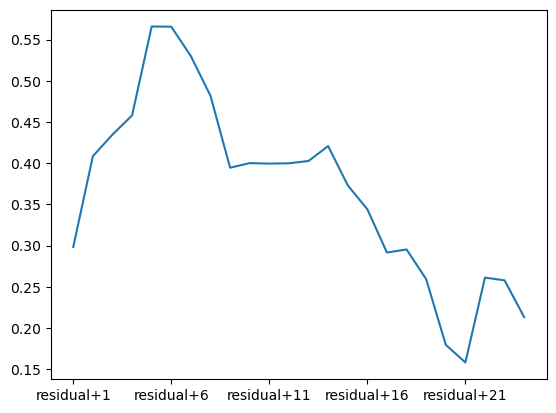

In [230]:
point_row.plot()

In [233]:
scenarios = simulation_uniform.copy()
# for each row of the simulation add the point forecast
for i in range(simulation_uniform.shape[0]):
    scenarios.iloc[i, :] = simulation_uniform.iloc[i, :] + point_row

<AxesSubplot:>

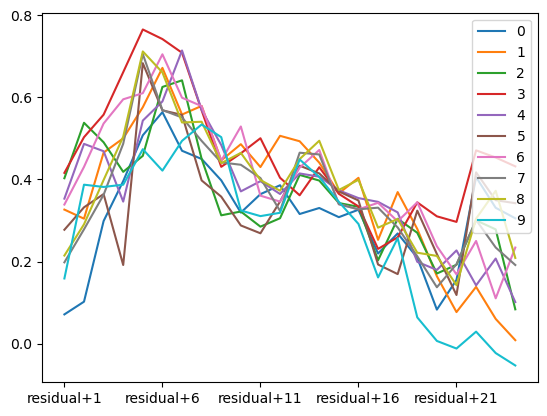

In [234]:
scenarios.T.plot()

<AxesSubplot:>

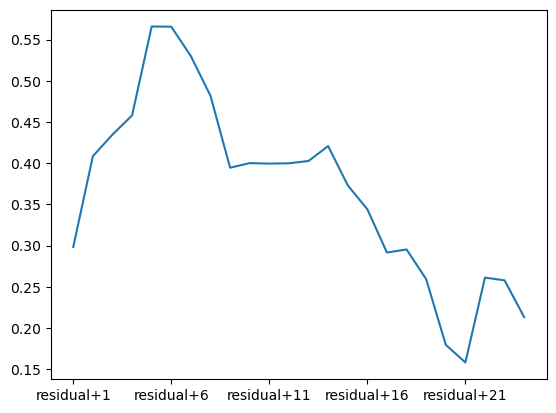

In [237]:
point_row.plot()

In [205]:
point_row = point_train[64:88]['net_forecast+1']
point_row.index = simulation_uniform.columns
point_row

residual+1     0.298346
residual+2     0.408575
residual+3     0.434689
residual+4     0.458011
residual+5     0.565925
residual+6     0.565645
residual+7     0.529915
residual+8     0.481801
residual+9     0.394516
residual+10    0.400120
residual+11    0.399505
residual+12    0.399910
residual+13    0.402708
residual+14    0.420768
residual+15    0.373188
residual+16    0.344075
residual+17    0.291586
residual+18    0.295317
residual+19    0.259333
residual+20    0.179665
residual+21    0.158167
residual+22    0.261152
residual+23    0.257829
residual+24    0.213181
Name: net_forecast+1, dtype: float64

<AxesSubplot:>

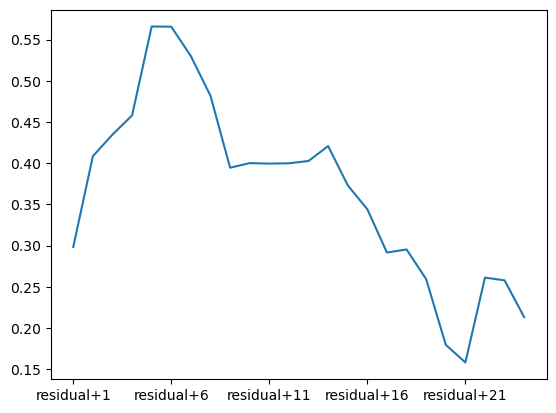

In [208]:
point_row.plot()

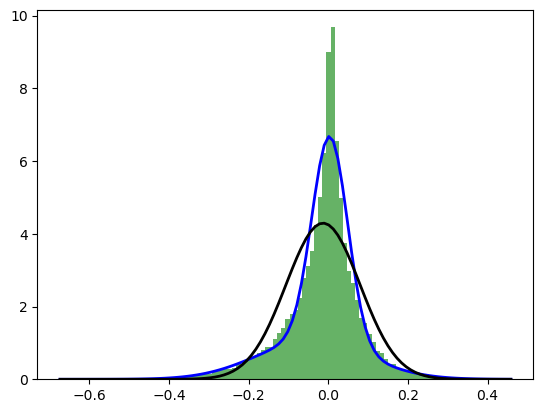

In [28]:
# estimate by a normal distribution
mu, std = norm.fit(data_train['residual'])
# fit to a gaussian mixture model
gmm = GaussianMixture(n_components=2).fit(data_train['residual'].values.reshape(-1, 1))
# plot the histogram and the normal distribution
plt.hist(data_train['residual'], bins=100, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = np.exp(gmm.score_samples(x.reshape(-1,1)))
# plot the PDF
plt.plot(x, y, 'b-', lw=2)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

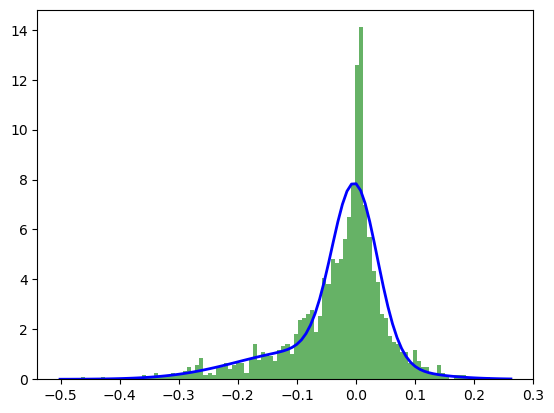

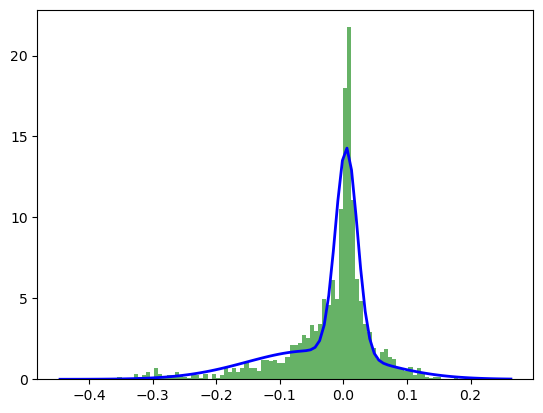

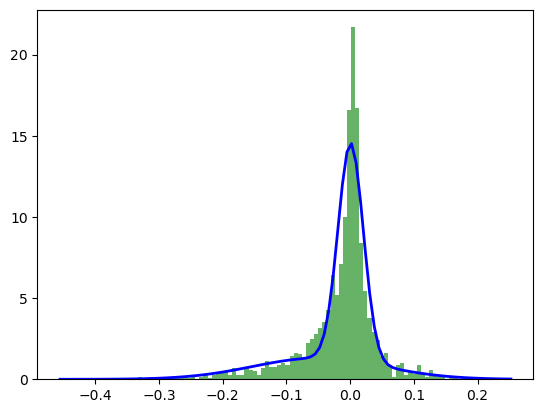

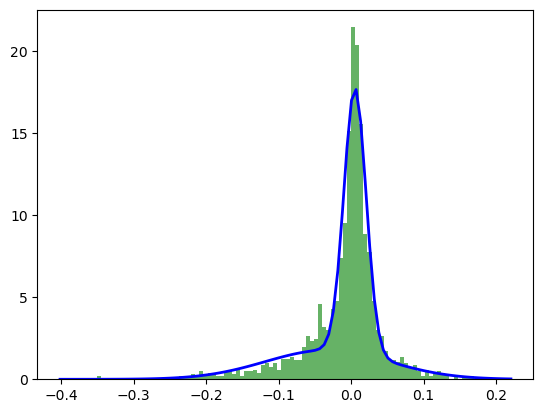

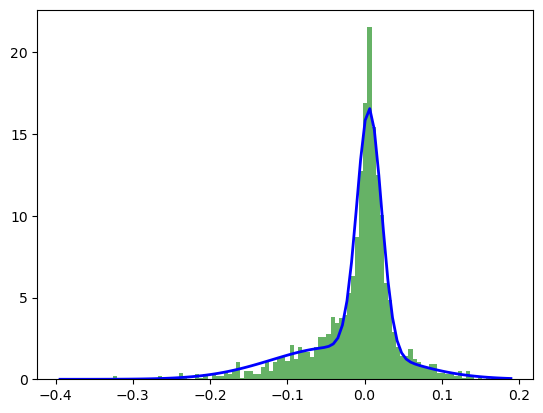

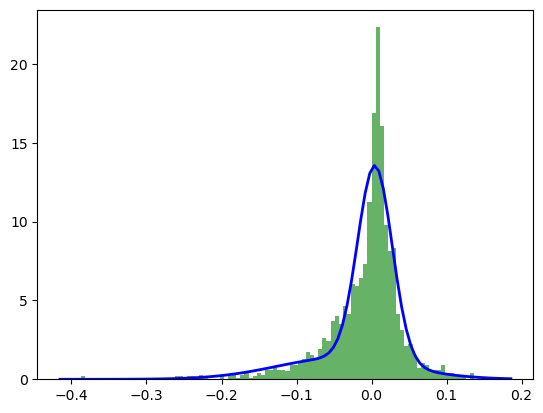

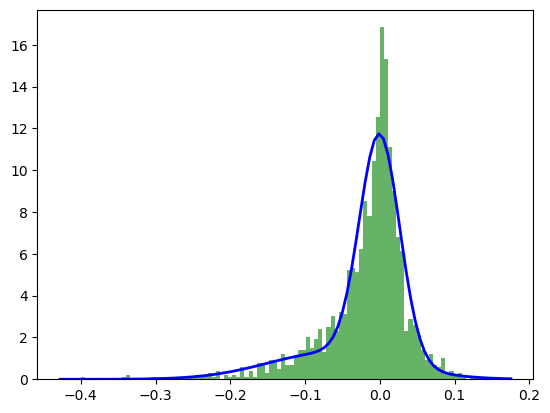

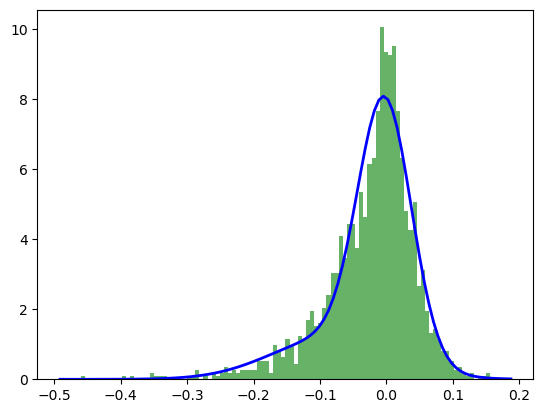

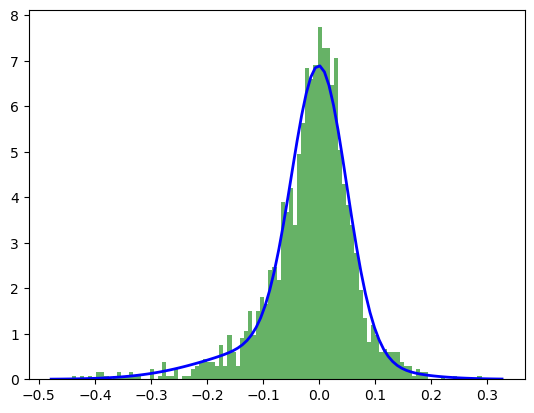

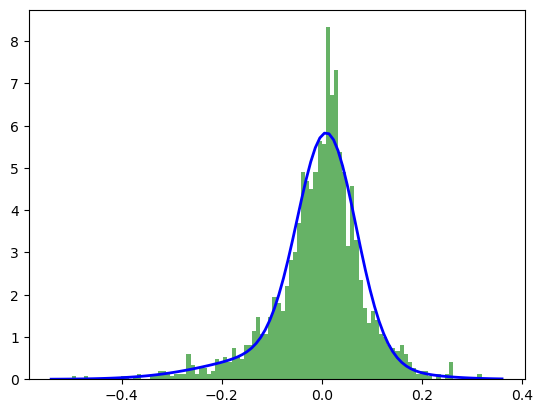

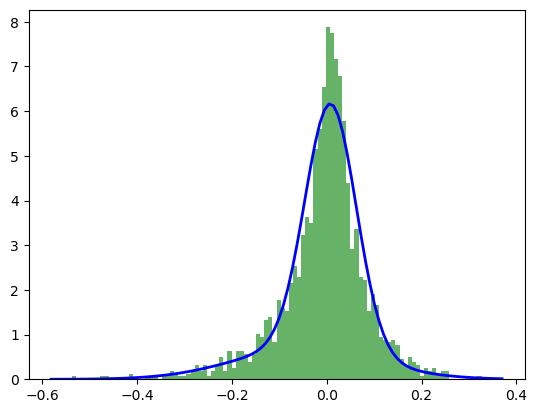

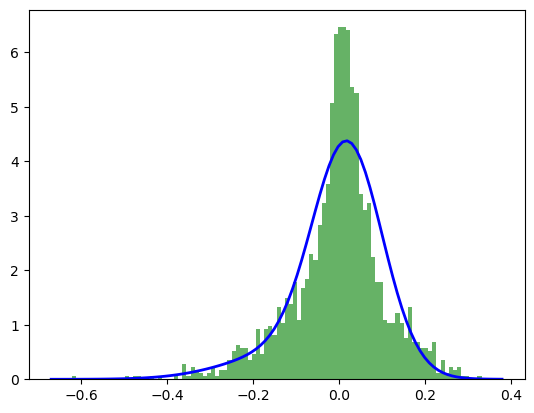

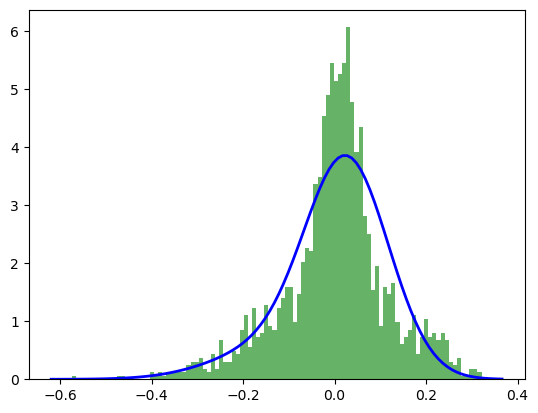

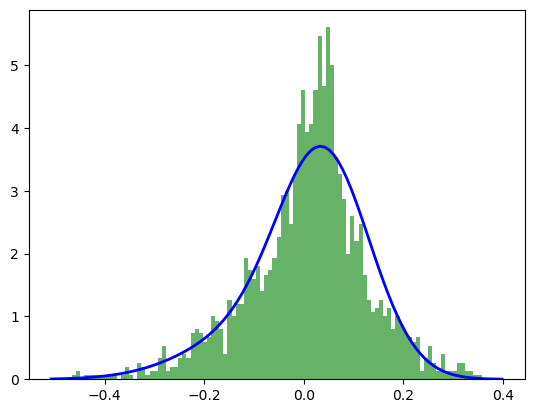

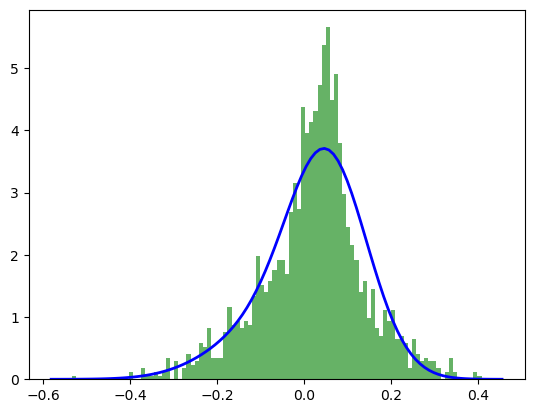

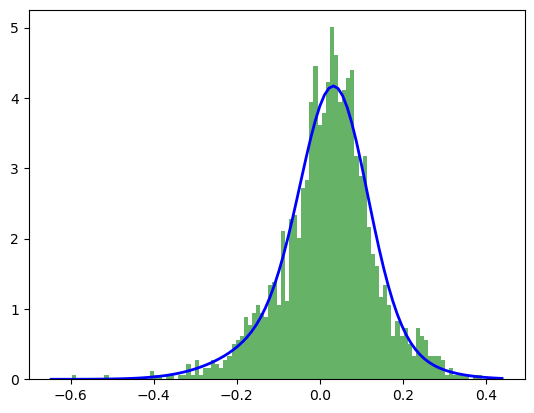

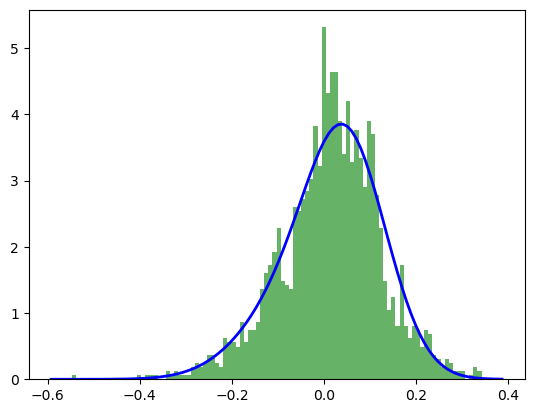

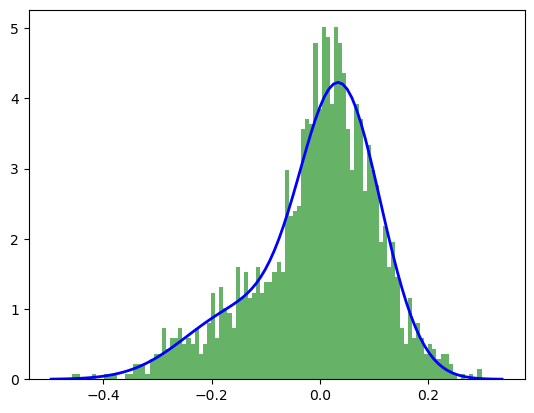

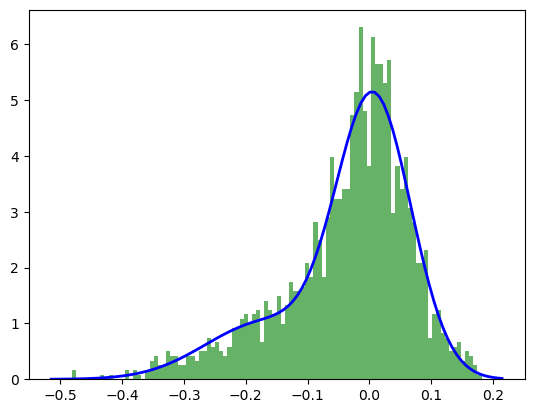

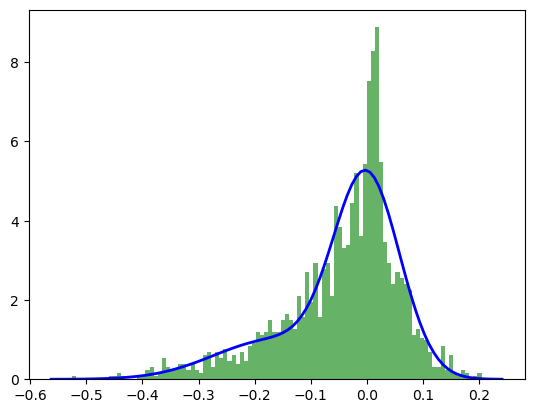

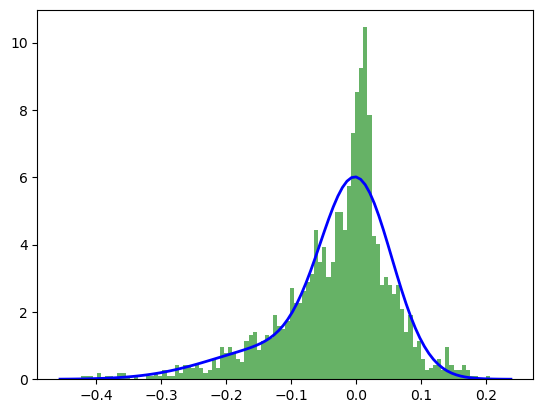

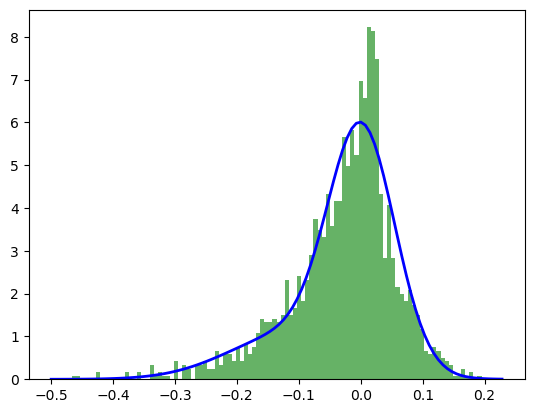

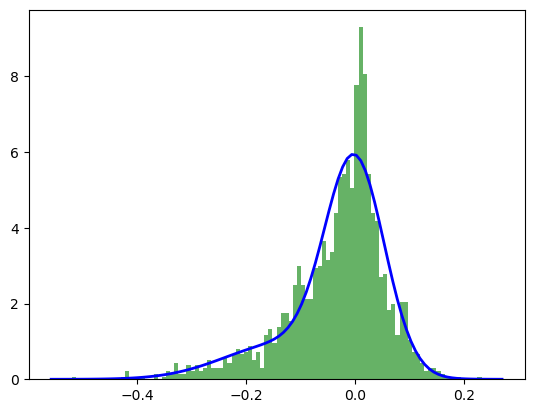

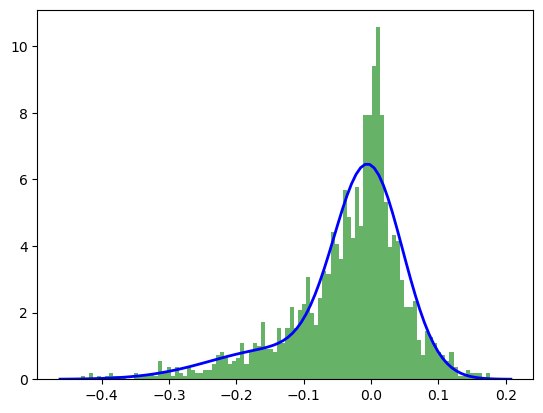

In [36]:
# find gmm for residuals for every Hour
gmm_dict = {}
for hour in data_train['Hour'].unique():
    gmm_dict[hour] = GaussianMixture(n_components=2).fit(data_train.loc[data_train['Hour'] == hour, 'residual'].values.reshape(-1, 1))
    # save the gmm parameters with joblib
    dump(gmm_dict[hour], 'models/gmm/gmm_residual_hour_{}.joblib'.format(int(hour)-1))
    # plot the histogram and the gmm
    plt.hist(data_train.loc[data_train['Hour'] == hour, 'residual'], bins=100, density=True, alpha=0.6, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = np.exp(gmm_dict[hour].score_samples(x.reshape(-1,1)))
    # plot the PDF
    plt.plot(x, y, 'b-', lw=2)
    plt.show()

<AxesSubplot:xlabel='Month'>

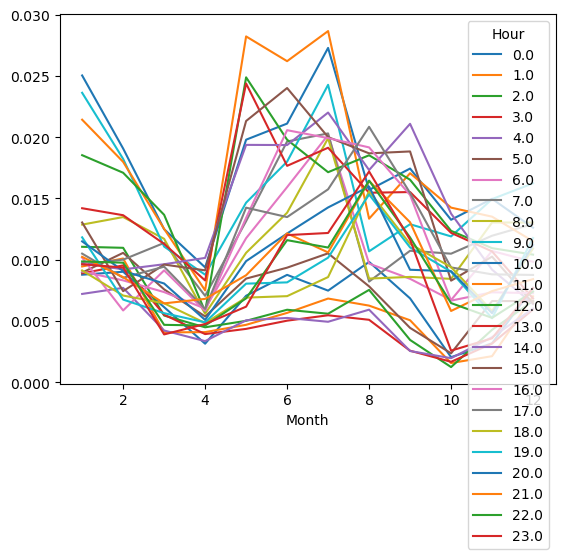

In [5]:
# show variance by hour and month
data_train.groupby(['Month', 'Hour']).var()[target].unstack().plot()

In [11]:
# calculate variance by hour and month
var_df = data_train.groupby(['Month', 'Hour']).var()[target].unstack()
# turn index and column names to int
var_df.index = var_df.index.astype(int)
var_df.columns = var_df.columns.astype(int)
var_df
# save to csv to data folder
var_df.to_csv('data/variance_hour_month.csv')

In [8]:
data_train.groupby(['Month', 'Hour']).var()[target].unstack()

Hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
Month,,,,,,,,,,,,,,,,,,,,,
1.0,0.008780,0.009453,0.011057,0.008894,0.007211,0.008951,0.009030,0.009625,0.012868,0.023625,...,0.009749,0.013043,0.010172,0.010501,0.009127,0.011829,0.011501,0.010236,0.009861,0.009635
2.0,0.009020,0.010102,0.010975,0.009540,0.007707,0.010563,0.008317,0.010008,0.013484,0.018229,...,0.009212,0.007439,0.005861,0.008532,0.007080,0.006751,0.009089,0.008583,0.009761,0.009362
3.0,0.006133,0.004070,0.005447,0.005516,0.004225,0.007584,0.007361,0.011373,0.011708,0.011075,...,0.009634,0.009608,0.009134,0.009434,0.006447,0.005640,0.008062,0.006441,0.004689,0.003908
4.0,0.003149,0.004095,0.004488,0.003935,0.003359,0.005374,0.006013,0.007058,0.005587,0.008783,...,0.010151,0.009136,0.005823,0.005992,0.004837,0.004895,0.005090,0.006808,0.004631,0.004757
5.0,0.007062,0.004691,0.005017,0.004359,0.005061,0.008463,0.011760,0.013148,0.010566,0.014658,...,0.019374,0.021323,0.013415,0.014250,0.006910,0.008050,0.009889,0.008736,0.006849,0.006172
6.0,0.008767,0.005664,0.005921,0.005029,0.005252,0.009354,0.015926,0.019651,0.013838,0.018007,...,0.019360,0.024014,0.020574,0.013483,0.007030,0.008154,0.012141,0.012149,0.011599,0.012011
7.0,0.007481,0.006834,0.005596,0.005469,0.004940,0.010525,0.020187,0.020309,0.019917,0.024276,...,0.022012,0.020010,0.019927,0.015748,0.008588,0.010170,0.014269,0.010597,0.010995,0.012185
8.0,0.009825,0.006257,0.007541,0.005101,0.005927,0.007829,0.009685,0.008221,0.008466,0.010688,...,0.017321,0.018683,0.019169,0.020845,0.015580,0.015326,0.015972,0.016433,0.016456,0.017201
9.0,0.006849,0.005061,0.003456,0.002577,0.002552,0.004440,0.008445,0.010735,0.008599,0.012900,...,0.021093,0.018838,0.015282,0.015449,0.011290,0.011006,0.009183,0.013058,0.011818,0.011635
